In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import numpy as np
from PIL import Image
import onnx

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('_object_noise.tif')], key=lambda x: int(os.path.basename(x).split('_')[0]))
        self.target_files = sorted([os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith('_noise.tif')], key=lambda x: int(os.path.basename(x).split('_')[0]))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image = ToTensor()(np.array(Image.open(self.input_files[idx]), dtype=np.float32) )
        target_image = ToTensor()(np.array(Image.open(self.target_files[idx]), dtype=np.float32) )
        return input_image, target_image

# ResNet-like Neural Network
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        return x + residual

# Parameters
input_dir = r"E:\Deeplearning\C11800\High\N2N\object_noise"
target_dir = r"E:\Deeplearning\C11800\High\N2N\noise"
batch_size = 32
epochs = 25
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader
dataset = CustomDataset(input_dir, target_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = SimpleResNet().to(device)

criterion = nn.L1Loss()  # MAE
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)

# Training Loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

# Save Model as ONNX
dummy_input = torch.randn(1, 1, 128, 128).to(device)
torch.onnx.export(model, dummy_input, "resnet_model.onnx", opset_version=11)


IndentationError: expected an indented block after 'if' statement on line 82 (2607297906.py, line 83)

In [ ]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
import os
import torch
import torch.nn as nn
from torchviz import make_dot
from IPython.display import Image, display
from torchviz import make_dot

class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()

        self.input = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv_final = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.input(x)  # Input層の適用
        xint = x

        residual1 = x
        x = self.block1(x)
        x += residual1  # Skip connection for block 1

        residual2 = x
        x = self.block2(x)
        x += residual2  # Skip connection for block 2

        residual3 = x
        x = self.block3(x)
        x += residual3  # Skip connection for block 3

        residual4 = x
        x = self.block4(x)
        x += residual4  # Skip connection for block 4

        x = self.conv_final(x)
        x += xint
        return x



def visualize_model():
    model = SimpleResNet()
    dummy_input = torch.randn(1, 1, 128, 128)  # Example input
    y = model(dummy_input)
    dot = make_dot(y, params=dict(model.named_parameters()))
    dot.format = "png"
    dot.render("resnet_model_visualization")
    print("Model visualization saved as 'resnet_model_visualization.png'")


def visualize_model_in_notebook():
    model = SimpleResNet()
    dummy_input = torch.randn(1, 1, 128, 128)  # Example input
    y = model(dummy_input)

    # Create the graph
    dot = make_dot(y, params=dict(model.named_parameters()))

    # Display the graph directly in the notebook
    dot.format = "png"
    dot.render("resnet_model_visualization", view=False)  # Save to file but do not open externally
    display(Image(filename="resnet_model_visualization.png"))  # Display the image in Jupyter Notebook
    print("Model visualization displayed in the notebook.")


visualize_model()
visualize_model_in_notebook()

RuntimeError: output with shape [1, 1, 128, 128] doesn't match the broadcast shape [1, 64, 128, 128]

In [13]:
import onnx
from onnxsim import simplify

# Load ONNX model
model_path = "resnet_model.onnx"
pruned_model_path = "resnet_model_pruned.onnx"

# Load and simplify the model
model = onnx.load(model_path)
simplified_model, check = simplify(model)

if check:
    # Save the simplified model
    onnx.save(simplified_model, pruned_model_path)
    print(f"Simplified model saved to {pruned_model_path}")
else:
    print("Model simplification failed.")


Simplified model saved to resnet_model_pruned.onnx


In [14]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Input and output model paths
pruned_model_path = "resnet_model_pruned.onnx"
quantized_model_path = "resnet_model_quantized.onnx"

# Perform dynamic quantization
quantize_dynamic(
    model_input=pruned_model_path,
    model_output=quantized_model_path,
    weight_type=QuantType.QInt8  # Quantize weights to INT8
)

print(f"Quantized model saved to {quantized_model_path}")


Quantized model saved to resnet_model_quantized.onnx


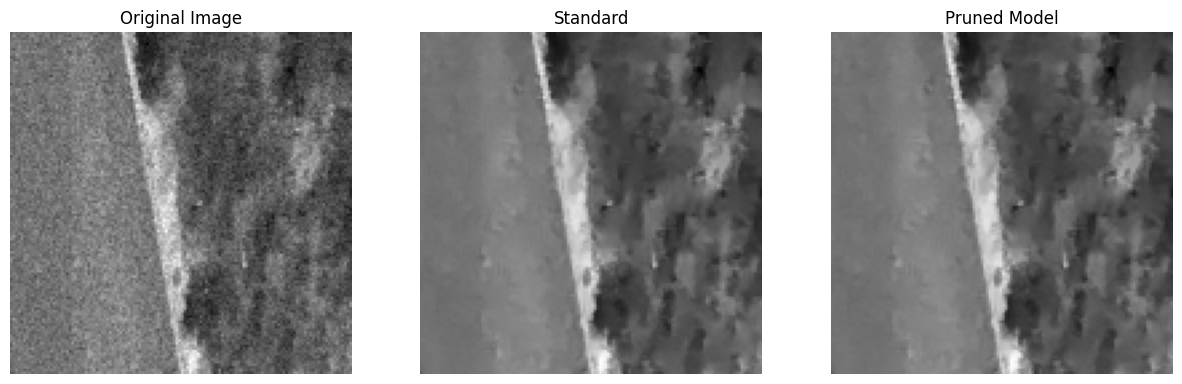

In [21]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
import os

# Load TIF image
def load_image(image_path):
    image = Image.open(image_path)
    image_array = np.array(image, dtype=np.float32)  # Normalize to [0, 1] for compatibility
    return image_array

def infer_with_onnx(model_path, input_image):
    session = ort.InferenceSession(model_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    input_name = session.get_inputs()[0].name
    input_image = input_image[np.newaxis, np.newaxis, :, :]  # Add batch and channel dimensions
    output = session.run(None, {input_name: input_image})[0]
    return output.squeeze()

# Save output image
def save_image(output_array, output_path):
    output_image = (output_array).clip(0, 65535).astype(np.uint16)  # Convert back to uint16
    Image.fromarray(output_image).save(output_path)

# Plot comparison
def plot_comparison(original, outputs, labels):
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, len(outputs) + 1, 1)
    plt.imshow(original, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Inferred outputs
    for i, (output, label) in enumerate(zip(outputs, labels), start=2):
        plt.subplot(1, len(outputs) + 1, i)
        plt.imshow(output, cmap="gray")
        plt.title(label)
        plt.axis("off")

    plt.show()

# Main script
if __name__ == "__main__":
    # File selection dialog
    Tk().withdraw()  # Hide the root window
    test_image_path = filedialog.askopenfilename(title="Select a TIF image", filetypes=[("TIF files", "*.tif")])

    if not test_image_path:
        print("No file selected. Exiting.")
        exit()

    # Create output directory
    input_dir = os.path.dirname(test_image_path)
    output_dir = os.path.join(input_dir, "Denoise")
    os.makedirs(output_dir, exist_ok=True)

    # Generate output file paths
    base_name = os.path.splitext(os.path.basename(test_image_path))[0]
    model_paths = ["resnet_model.onnx", "resnet_model_pruned.onnx"]
    output_paths = [
        os.path.join(output_dir, f"{base_name}_Standard.tif"),
        os.path.join(output_dir, f"{base_name}_Pruned.tif")
    ]

    # Labels for comparison
    labels = ["Standard", "Pruned Model"]

    # Load test image
    test_image = load_image(test_image_path)

    # Perform inference and save results
    outputs = []
    for model_path, output_path in zip(model_paths, output_paths):
        output = infer_with_onnx(model_path, test_image)
        save_image(output, output_path)
        outputs.append(output)

    # Plot comparison
    plot_comparison(test_image, outputs, labels)
